In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

np.random.seed(1234)

import torch
import torch.nn as nn
from torch.utils import data
import torchvision.models as models
from torchvision import transforms

from hack_utils import NUM_PTS, CROP_SIZE
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys, HorizontalFlip
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission


import albumentations as albu

# import torch.optim as optim

import tqdm

In [2]:
train_dataset = torch.load('../data/datasets.pth')['train_dataset']
train_dataset[0]['landmarks'].shape

torch.Size([1942])

### Visualizing transforms (given + albumentations)

(361, 297, 3)


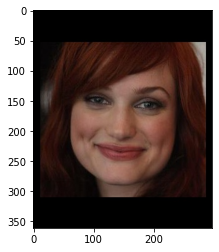

In [3]:
from hack_utils import NUM_PTS, CROP_SIZE
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys

def vis_points(image, points, diameter=1):
    im = image.copy()

    for (x, y) in points:
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.imshow(im)

index = 1
image = cv2.imread(train_dataset.image_names[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

sample = {
    'image' : image,
    'landmarks' : train_dataset.landmarks[index]
}
plt.imshow(image)

834


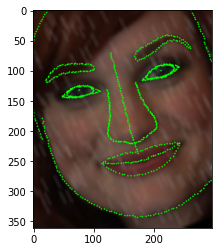

In [9]:
transforms_albu = albu.Compose([
    albu.ShiftScaleRotate(scale_limit=(-0.05, 1), rotate_limit=20, p=1, border_mode=0),
                        albu.RandomRain(p=1),
                        albu.Blur(p=0.1),
                        albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.2),
#                         albu.ChannelShuffle(p=0.1),
                       ],
                      keypoint_params=albu.KeypointParams(format='xy'))
sample0 = transforms_albu(image=sample['image'], keypoints=sample['landmarks'])
vis_points(sample0['image'], sample0['keypoints'])
print(len(sample0['keypoints']))

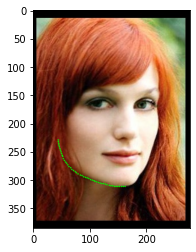

In [4]:
vis_points(image, sample['landmarks'][:50])

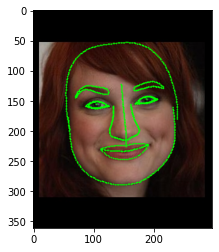

In [10]:
sample0 = HorizontalFlip(p=1)(sample)
vis_points(sample0['image'], sample0['landmarks'])

(178, 128, 3)


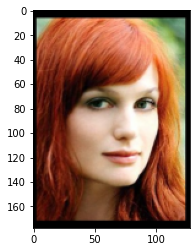

In [4]:
sample1 = ScaleMinSideToSize((CROP_SIZE, CROP_SIZE))(sample)
print(sample1['image'].shape)
plt.imshow(sample1['image'])

(128, 128, 3)


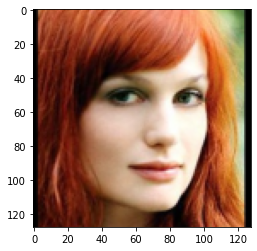

In [5]:
sample2 = CropCenter(CROP_SIZE)(sample1)
print(sample2['image'].shape)
plt.imshow(sample2['image'])

### Check checkpoint scores

In [3]:
training_state = torch.load('../data/checkpoints/resnext50_32x4d_10/training_state.pth', map_location='cpu')

In [4]:
for i in training_state:
    print(i)

best_checkpoints
best_scores
epoch
best_checkpoints
best_scores
epoch


In [5]:
training_state['epoch']

[51, 72, 62]

[51, 72, 62]

In [9]:
training_state['best_scores']

[1.5206948611643407, 1.5256567891542014, 1.5257804842738363]

[1.5206948611643407, 1.5256567891542014, 1.5257804842738363]

### Create submission

In [6]:
import pretrainedmodels
device = 'cuda:0'
model = pretrainedmodels.senet154(num_classes=1000, pretrained='imagenet')
model.last_linear = nn.Linear(model.last_linear.in_features, 2 * NUM_PTS, bias=True)
model = nn.DataParallel(model)
model.load_state_dict(training_state['best_checkpoints'][0])
model.to(device)

DataParallel(
  (module): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.

In [7]:
crop_size = 224
train_transforms = transforms.Compose([
    ScaleMinSideToSize((crop_size, crop_size)),
    CropCenter(crop_size),
    TransformByKeys(transforms.ToPILImage(), ('image',)),
    TransformByKeys(transforms.ToTensor(), ('image',)),
    TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ('image',)),
    # TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ('image',)),
])
test_dataset = torch.load('../data/datasets.pth')['test_dataset']
test_dataset.transforms = train_transforms
test_dataloader = data.DataLoader(test_dataset, batch_size=100, num_workers=4, pin_memory=False,
                                  shuffle=False, drop_last=False)

In [8]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc='test prediction...')):
        images = batch['image'].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch['scale_coef'].numpy()  # B
        margins_x = batch['crop_margin_x'].numpy()  # B
        margins_y = batch['crop_margin_y'].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [11]:
# test_predictions = predict(model, test_dataloader, device)
checkpoint_path = '/data/rustem/landmarks/data/checkpoints/senet154_00/'
with open(os.path.join(checkpoint_path, f'senet154_test_predictions.pkl'), 'wb') as fp:
    pickle.dump({'image_names': test_dataset.image_names,
                 'landmarks': test_predictions}, fp)

In [13]:
create_submission('/data/rustem/landmarks/data/', test_predictions, os.path.join(checkpoint_path, f'senet154_submit.csv'))
